In [1]:
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import uniform, randint
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV,train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score
)


In [6]:
# Load four data files
order_items = pd.read_csv(r"D:\桌面\project\data\clean\order_items.csv")
reviews = pd.read_csv(r"D:\桌面\project\data\clean\olist_order_reviews_dataset.csv")
orders = pd.read_csv(r"D:\桌面\project\data\clean\orders_dataset.csv", parse_dates=["order_purchase_timestamp"])
products = pd.read_csv(r"D:\桌面\project\data\clean\products.csv")

# Sort order data by purchase timestamp
orders_sorted = orders.sort_values(by="order_purchase_timestamp", ascending=True)


Merge tables

In [7]:
# Merge order_items → orders → products → reviews in sequence
merged_df = pd.merge(order_items, orders, on="order_id", how="inner")
merged_df = pd.merge(merged_df, products, on="product_id", how="left")
merged_df = pd.merge(merged_df, reviews[['order_id', 'review_score']], on="order_id", how="inner")

# Inspect the structure of the merged dataset
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108403 entries, 0 to 108402
Data columns (total 30 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       108403 non-null  object        
 1   order_item_id                  108403 non-null  int64         
 2   product_id                     108403 non-null  object        
 3   seller_id                      108403 non-null  object        
 4   shipping_limit_date            108403 non-null  object        
 5   price                          108403 non-null  float64       
 6   freight_value                  108403 non-null  float64       
 7   year_month                     108403 non-null  object        
 8   month                          108403 non-null  int64         
 9   weekday                        108403 non-null  int64         
 10  price_freight_ratio            108403 non-null  float64       
 11  

## Feature Engineering

In [8]:
# Aggregate by order_id to compute total order value and the number of items per order
order_agg = merged_df.groupby('order_id').agg(
    total_order_value=('price', 'sum'),
    total_order_count=('order_item_id', 'count')
).reset_index()

# Merge the aggregated results back into the original dataset
merged_df = pd.merge(merged_df, order_agg, on='order_id', how='left')


In [9]:
# Construct new features
merged_df['price_per_weight'] = merged_df['price'] / merged_df['product_weight_g'].replace(0, np.nan)
merged_df['description_density'] = merged_df['product_description_lenght'] / merged_df['product_name_lenght'].replace(0, np.nan)
merged_df['freight_ratio'] = merged_df['freight_value'] / merged_df['price'].replace(0, np.nan)
merged_df['delivery_ratio'] = merged_df['delivery_time'] / merged_df['shipping_time'].replace(0, np.nan)

# Construct time-related features
merged_df['month'] = merged_df['order_purchase_timestamp'].dt.month
merged_df['weekday'] = merged_df['order_purchase_timestamp'].dt.weekday

# List of all features
engineered_features = [
    'price', 'freight_value', 'price_freight_ratio', 'product_photos_qty',
    'product_name_lenght', 'product_description_lenght', 'product_weight_g',
    'product_length_cm', 'product_height_cm', 'product_width_cm',
    'processing_time_approved', 'shipping_time', 'delivery_time',
    'total_order_value', 'total_order_count', 'month', 'weekday',
    'price_per_weight', 'description_density', 'freight_ratio', 'delivery_ratio'
]


# Evaluate feature importance using the mutual information method.

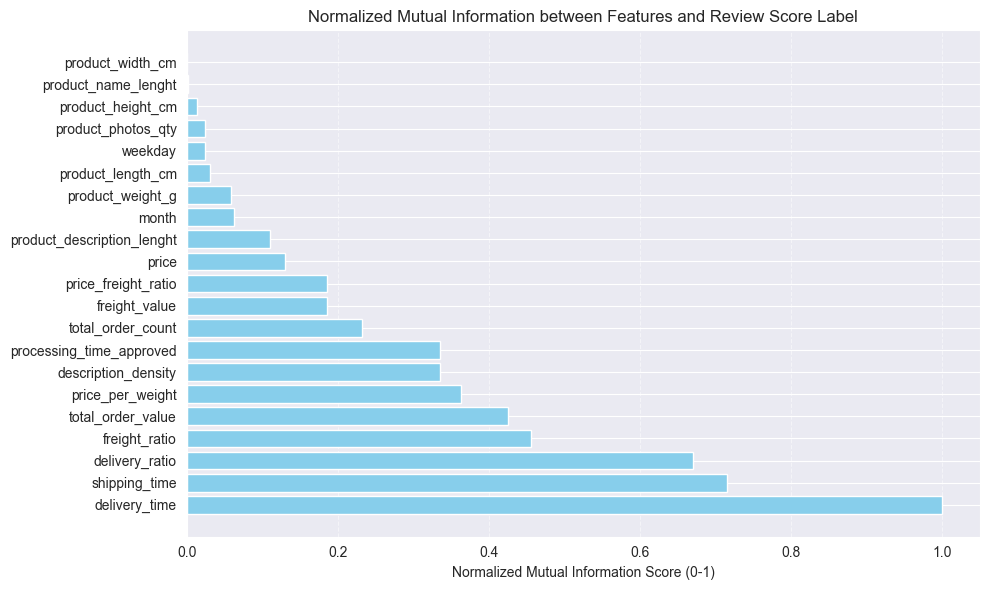

                       feature  mutual_information  normalized_mi
12               delivery_time            0.096659       1.000000
11               shipping_time            0.069130       0.715194
20              delivery_ratio            0.064723       0.669601
19               freight_ratio            0.044079       0.456025
13           total_order_value            0.041137       0.425594
17            price_per_weight            0.035063       0.362747
18         description_density            0.032459       0.335816
10    processing_time_approved            0.032420       0.335402
14           total_order_count            0.022410       0.231850
1                freight_value            0.017989       0.186112
2          price_freight_ratio            0.017984       0.186060
0                        price            0.012525       0.129579
5   product_description_lenght            0.010690       0.110595
15                       month            0.006081       0.062912
6         

In [10]:
# Prepare data by removing missing values
mi_df = merged_df[engineered_features + ['review_score']].dropna()
mi_df['review_label'] = mi_df['review_score'].apply(lambda x: 1 if x >= 4 else 0)

# Features and labels
X = mi_df[engineered_features]
y = mi_df['review_label']

# Compute mutual information
mi_scores = mutual_info_classif(X, y, discrete_features=False, random_state=42)

# Normalize mutual information to the [0, 1] range
max_mi = mi_scores.max()
normalized_mi = mi_scores / max_mi if max_mi > 0 else mi_scores

# Organize results into a DataFrame
mi_result = pd.DataFrame({
    'feature': engineered_features,
    'mutual_information': mi_scores,
    'normalized_mi': normalized_mi  # Add normalized mutual information column
}).sort_values(by='mutual_information', ascending=False)

# Visualize normalized mutual information
plt.figure(figsize=(10, 6))
plt.barh(mi_result['feature'], mi_result['normalized_mi'], color='skyblue')
plt.title('Normalized Mutual Information between Features and Review Score Label')
plt.xlabel('Normalized Mutual Information Score (0-1)')
plt.tight_layout()
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.show()

# Display the normalized result
print(mi_result.sort_values(by='normalized_mi', ascending=False))

To identify the important variables affecting review ratings, we used the Mutual Information (MI) method to evaluate the nonlinear dependency between each feature and the target variable. Mutual information can capture more complex statistical relationships and is more robust to data with class imbalance and nonlinear structures compared to traditional metrics such as linear correlation coefficients.

- Delivery_time scored the highest in the normalized mutual information (normalized_mi = 1.000), indicating the strongest information correlation with the rating outcome. Specifically, delayed or on-time delivery has a significant impact on customer satisfaction, which is consistent with the conclusion in previous studies that "logistics timeliness is a core element of users' experience on e-commerce platforms.“

- Variables directly related to shipping efficiency and performance ratio, such as shipping_time and delivery_ratio, also show high correlation, indicating that logistics performance is an important basis for users' scoring decisions.

- In addition, variables reflecting price structure and cost-performance ratio such as freight_ratio and price_per_weight also show certain information value, indicating the impact of freight burden and product pricing on customer perception.

- In contrast, variables related to product description dimensions such as product_photos_qty, product_height_cm, product_width_cm, and product_name_length have mutual information values close to zero. This indicates weak statistical association with the rating outcomes, suggesting these fields may contribute limited value to the model. They can be considered for exclusion in subsequent feature selection or dimensionality reduction processes.

In summary, this correlation analysis provides a clear basis for feature prioritization in model construction. In the subsequent modeling phase, I selected and retained the top nine features with the highest correlation to input into the model for training.

### Split the dataset into training set and test set

In [11]:
# Use the features recommended in the previous step
final_features = [
    'delivery_time',
    'shipping_time',
    'delivery_ratio',
    'freight_ratio',
    'total_order_value',
    'price_per_weight',
    'description_density',
    'processing_time_approved',
    'total_order_count'
]

# Data preprocessing
model_df = merged_df[final_features + ['review_score']].dropna()
model_df['review_label'] = model_df['review_score'].apply(lambda x: 1 if x >= 4 else 0)

# Raw data preparation (including features and review_label)
data = model_df[final_features + ['review_label']].dropna()

# First, split the raw data into a training set and a validation set
train_df, valid_df = train_test_split(
    data, test_size=0.2, random_state=42, stratify=data['review_label']
)
# Save as a CSV file
train_df.to_csv(r"D:\桌面\project\data\clean\train.csv", index=False)
valid_df.to_csv(r"D:\桌面\project\data\clean\valid.csv", index=False)


# Model Training
In this study, to address the severe class imbalance in user rating data and accurately predict ratings, we systematically compared the performance of four categories of mainstream machine learning models: Logistic Regression, Balanced Random Forest, XGBoost, and a Stacking ensemble model using the first three as base models. Through comparative analysis of multiple parameters, the Stacking model constructed with XGBoost and Random Forest as base models and Logistic Regression as the meta-learner was ultimately selected as the optimal prediction model for this task.

## XGboost

In [4]:
# Read CSV data
train_df = pd.read_csv(r"D:\桌面\project\data\clean\train.csv")
valid_df = pd.read_csv(r"D:\桌面\project\data\clean\valid.csv")

Fitting 3 folds for each of 200 candidates, totalling 600 fits


D:\桌面\pythonProject4\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:31:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
D:\桌面\pythonProject4\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:31:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
D:\桌面\pythonProject4\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:31:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
D:\桌面\pythonProject4\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:31:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.up

=== Best Parameters (XGBoost) ===
{'colsample_bytree': 0.7118280434105517, 'gamma': 0.2822300690062754, 'learning_rate': 0.19504966348313318, 'max_depth': 9, 'min_child_weight': 2, 'n_estimators': 164, 'scale_pos_weight': 2, 'subsample': 0.9746464892764125}

=== Classification Report (XGBoost) ===
Class 0:
  Precision: 0.6583
  Recall:    0.4349
  F1-score:  0.5238
  Support:   5698.0

Class 1:
  Precision: 0.8266
  Recall:    0.9227
  F1-score:  0.8720
  Support:   16639.0

Overall Accuracy: 0.7982719255047679
Macro Avg F1-score: 0.6979057947833113
Weighted Avg F1-score: 0.78319556847057


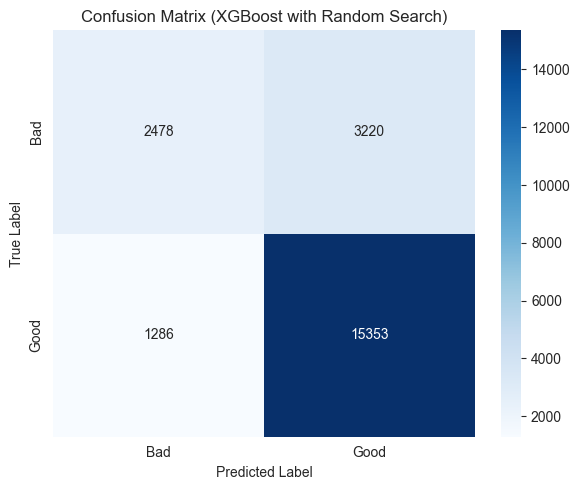

In [26]:

# Use the features recommended in the previous step
final_features = [
    'delivery_time',
    'shipping_time',
    'delivery_ratio',
    'freight_ratio',
    'total_order_value',
    'price_per_weight',
    'description_density',
    'processing_time_approved',
    'total_order_count'
]
# Separate features and labels
X_train = train_df[final_features]
y_train = train_df['review_label']

X_test = valid_df[final_features]
y_test = valid_df['review_label']

# Construct an XGBoost model
xgb = XGBClassifier(
    scale_pos_weight=5,  # Apply stronger penalties to the minority class
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Define the parameter search space (wider range)
param_dist = {
    'n_estimators': randint(80, 200),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3),
    'gamma': uniform(0, 0.4),
    'min_child_weight': randint(1, 6),
    'scale_pos_weight': [1, 2, 3]  # Address class imbalance
}

# Perform hyperparameter tuning using RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=200,  # Number of iterations
    scoring='f1',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=1
)

# Apply SMOTE oversampling to the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train and tune the model
random_search.fit(X_train_resampled, y_train_resampled)

# Predict and evaluate using the best model
xgb_model = random_search.best_estimator_
# Predictions
y_pred = xgb_model.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print results
print("=== Best Parameters (XGBoost) ===")
print(random_search.best_params_)

print("\n=== Classification Report (XGBoost) ===")
for label in ['0', '1']:
    precision = report[label]['precision']
    recall = report[label]['recall']
    f1 = report[label]['f1-score']
    support = report[label]['support']
    print(f"Class {label}:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-score:  {f1:.4f}")
    print(f"  Support:   {support}")
    print()

print("Overall Accuracy:", report['accuracy'])
print("Macro Avg F1-score:", report['macro avg']['f1-score'])
print("Weighted Avg F1-score:", report['weighted avg']['f1-score'])

# Visualize the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Bad', 'Good'], yticklabels=['Bad', 'Good'])
plt.title("Confusion Matrix (XGBoost with Random Search)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


### XGBoost Model Analysis
XGBoost performs excellently in terms of accuracy by virtue of its excellent regularization mechanism and flexible parameter control, and it supports adjusting class imbalance to a certain extent through the scale_pos_weight mechanism. However, it is difficult to achieve an ideal balance between accuracy and recall, especially when identifying the minority class (negative reviews), where its performance fluctuates significantly.

# Random Forest

Fitting 3 folds for each of 18 candidates, totalling 54 fits
=== Best Parameters ===
{'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 200}

=== Classification Report ===
Class 0:
  Precision: 0.6709
  Recall:    0.5895
  F1-score:  0.6276
  Support:   5698.0

Class 1:
  Precision: 0.8650
  Recall:    0.9010
  F1-score:  0.8826
  Support:   16639.0

Overall Accuracy: 0.8215069167748579
Macro Avg F1-score: 0.7550927474894032
Weighted Avg F1-score: 0.8175615771104623


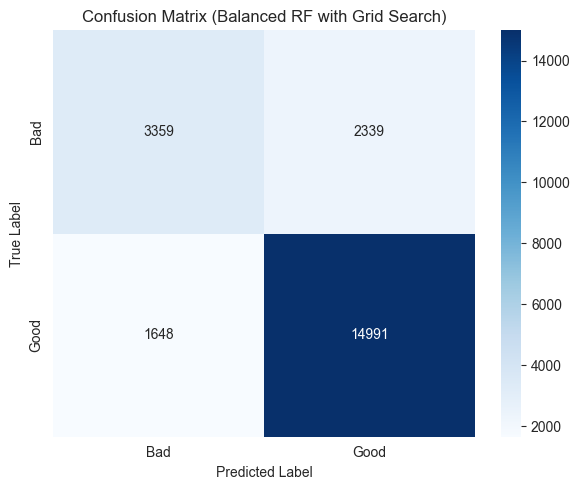

In [10]:
# Feature Selection
final_features = [
    'delivery_time', 'shipping_time', 'delivery_ratio', 'freight_ratio',
    'total_order_value', 'price_per_weight', 'description_density',
    'processing_time_approved', 'total_order_count'
]

# Separate features and labels
X_train = train_df[final_features]
y_train = train_df['review_label']

X_test = valid_df[final_features]
y_test = valid_df['review_label']

# Apply SMOTE oversampling to the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


# Parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 2, 5]
}

# Build GridSearchCV
grid_search = GridSearchCV(
    estimator=BalancedRandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit the search
grid_search.fit(X_train, y_train)
rf_model = grid_search.best_estimator_

# Predictions
y_pred = rf_model.predict(X_test)

# Classification report
report = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print results
print("=== Best Parameters ===")
print(grid_search.best_params_)

print("\n=== Classification Report ===")
for label in ['0', '1']:
    precision = report[label]['precision']
    recall = report[label]['recall']
    f1 = report[label]['f1-score']
    support = report[label]['support']
    print(f"Class {label}:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-score:  {f1:.4f}")
    print(f"  Support:   {support}")
    print()

print("Overall Accuracy:", report['accuracy'])
print("Macro Avg F1-score:", report['macro avg']['f1-score'])
print("Weighted Avg F1-score:", report['weighted avg']['f1-score'])

#Visualize the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Bad', 'Good'], yticklabels=['Bad', 'Good'])
plt.title("Confusion Matrix (Balanced RF with Grid Search)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


### RandomForest Model Analysis
As a classic ensemble learning method, RandomForest is stable in modeling and easy to tune parameters, demonstrating good overall accuracy. However, its recognition of negative reviews is still limited by the bias caused by class imbalance, resulting in moderate performance in identifying the minority class (negative reviews).

# LogisticRegression

Fitting 3 folds for each of 4 candidates, totalling 12 fits
=== Best Parameters (Logistic Regression) ===
{'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}

=== Classification Report (Logistic Regression) ===
Class 0:
  Precision: 0.4027
  Recall:    0.5411
  F1-score:  0.4617
  Support:   5698.0

Class 1:
  Precision: 0.8219
  Recall:    0.7252
  F1-score:  0.7705
  Support:   16639.0

Overall Accuracy: 0.6782020862246497
Macro Avg F1-score: 0.6161161980539359
Weighted Avg F1-score: 0.6917347778686725


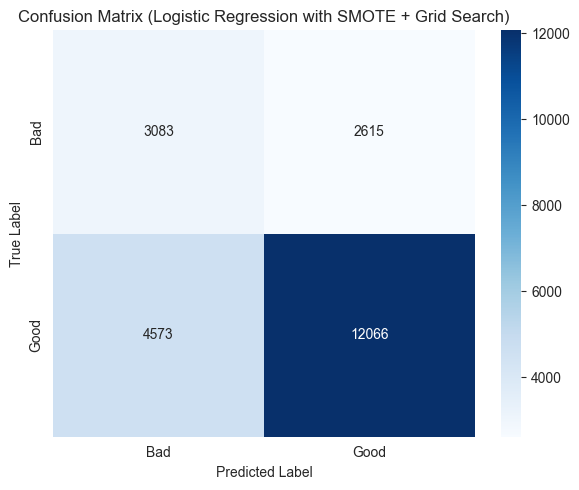

In [32]:
# Feature Preparation
final_features = [
    'delivery_time',
    'shipping_time',
    'delivery_ratio',
    'freight_ratio',
    'total_order_value',
    'price_per_weight',
    'description_density',
    'processing_time_approved',
    'total_order_count'
]

# Split Training and Test Sets
X_train = train_df[final_features]
y_train = train_df['review_label']
X_test = valid_df[final_features]
y_test = valid_df['review_label']

# Build Logistic Regression Training Pipeline
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

# Parameter Grid
param_grid = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__penalty': ['l2'],  # 'l1' can also be tried (requires solver='liblinear')
    'clf__solver': ['lbfgs']  # 'liblinear' supports l1 and l2; lbfgs is better for l2
}

# GridSearchCV Hyperparameter Tuning
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Model Training
grid_search.fit(X_train, y_train)
lr_model = grid_search.best_estimator_

# Model Prediction
y_pred = lr_model.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)

# Output Evaluation Results
print("=== Best Parameters (Logistic Regression) ===")
print(grid_search.best_params_)

print("\n=== Classification Report (Logistic Regression) ===")
for label in ['0', '1']:
    precision = report[label]['precision']
    recall = report[label]['recall']
    f1 = report[label]['f1-score']
    support = report[label]['support']
    print(f"Class {label}:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-score:  {f1:.4f}")
    print(f"  Support:   {support}")
    print()

print("Overall Accuracy:", report['accuracy'])
print("Macro Avg F1-score:", report['macro avg']['f1-score'])
print("Weighted Avg F1-score:", report['weighted avg']['f1-score'])

# Confusion Matrix Visualization
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Bad', 'Good'], yticklabels=['Bad', 'Good'])
plt.title("Confusion Matrix (Logistic Regression with SMOTE + Grid Search)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

### Logistic Regression Model Analysis
As a linear model with high computational efficiency and simple implementation, logistic regression has advantages in interpretability and is suitable for tasks with relatively linear relationships between features. However, in this dataset, the rating behavior is complex and the nonlinear interaction of features is significant, resulting in obvious deficiencies in the identification of negative review samples by logistic regression, especially the low recall rate, which cannot meet the business requirements for early identification of "risk orders".

# Ensemble Learning — XGB + RF + LR

Fitting 3 folds for each of 48 candidates, totalling 144 fits


D:\桌面\pythonProject4\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
16 fits failed out of a total of 144.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "D:\桌面\pythonProject4\.venv\Lib\site-packages\joblib\_utils.py", line 72, in __call__
    return self.func(**kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "D:\桌面\pythonProject4\.venv\Lib\site-packages\joblib\parallel.py", line 607, in __call__
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\桌面\pythonP

Best parameters: {'final_estimator__C': 0.1, 'rf__max_depth': None, 'rf__n_estimators': 200, 'xgb__max_depth': 3, 'xgb__n_estimators': 50}
=== Classification Report ===
              precision    recall  f1-score   support

           0     0.6272    0.5530    0.5878      5698
           1     0.8529    0.8874    0.8698     16639

    accuracy                         0.8021     22337
   macro avg     0.7400    0.7202    0.7288     22337
weighted avg     0.7953    0.8021    0.7979     22337



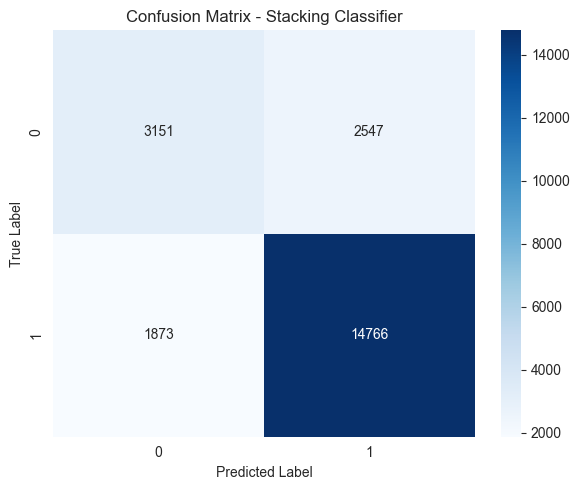

In [25]:
# Feature Preparation
final_features = [
    'delivery_time',
    'shipping_time',
    'delivery_ratio',
    'freight_ratio',
    'total_order_value',
    'price_per_weight',
    'description_density',
    'processing_time_approved',
    'total_order_count'
]

# Oversampling
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Standardization
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

from sklearn.model_selection import GridSearchCV

# Build Base Models (as above)
estimators = [
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)),
    ('rf', RandomForestClassifier(random_state=42)),
    ('lr', LogisticRegression(max_iter=1000, random_state=42))
]

# Build Initial Stacking Model (basic, no hyperparameter tuning)
base_stack = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5,
    n_jobs=-1
)

# Hyperparameter Grid
param_grid = {
    'xgb__n_estimators': [50, 100],
    'xgb__max_depth': [3, 5],
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 10],
    'final_estimator__C': [0.1, 1.0, 10.0]
}

# Grid Search for Hyperparameter Tuning
grid_search = GridSearchCV(
    estimator=base_stack,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Training with Grid Search
grid_search.fit(X_train_res_scaled, y_train_res)

# Optimal Model
stack_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)


# Prediction and Evaluation
y_pred = stack_model.predict(X_test_scaled)
report = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)

# Output Results
print("=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix Visualization
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Stacking Classifier")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


### Ensemble Learning(XGB + RF + LR) Model Analysis
- Determine the optimal parameter combination of the model through grid search.
 
- Evaluate the performance of the base models through 5-fold cross-validation to prevent overfitting.

- Use SMOTE oversampling to handle class imbalance.
  
- Using multiple models and ensemble methods to effectively capture complex relationships in the data.

To further enhance the overall performance and robustness of the model, we constructed a Stacking ensemble model that uses the prediction results of XGBoost and RandomForest as inputs and fuses them through a logistic regression meta-classifier for learning. This approach achieved optimal results across multiple evaluation metrics (such as F1 score, minority class recall, and AUC), particularly demonstrating higher stability and accuracy in identifying potential negative review orders. Compared with single models, Stacking comprehensively leverages the modeling advantages of multiple models for different feature structures, effectively reducing model bias and enhancing adaptability to imbalanced sample structures.

# Model Evaluation

D:\桌面\pythonProject4\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but BalancedRandomForestClassifier was fitted with feature names
  warnings.warn(
D:\桌面\pythonProject4\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but BalancedRandomForestClassifier was fitted with feature names
  warnings.warn(
D:\桌面\pythonProject4\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\桌面\pythonProject4\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


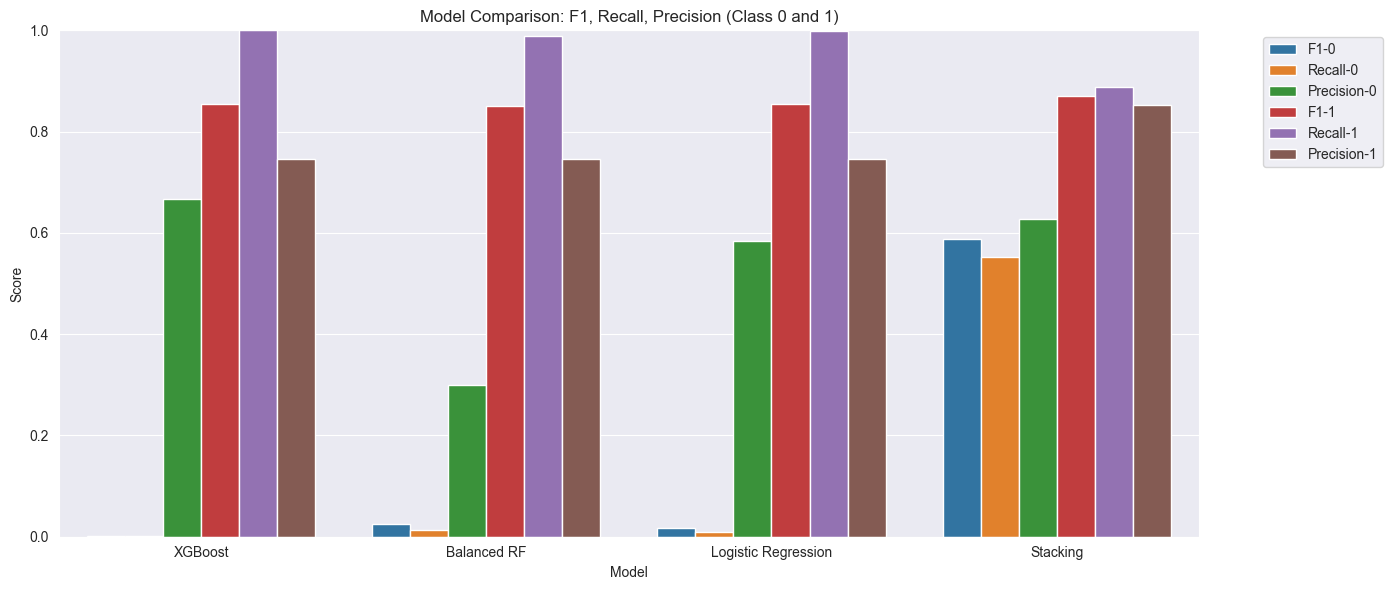

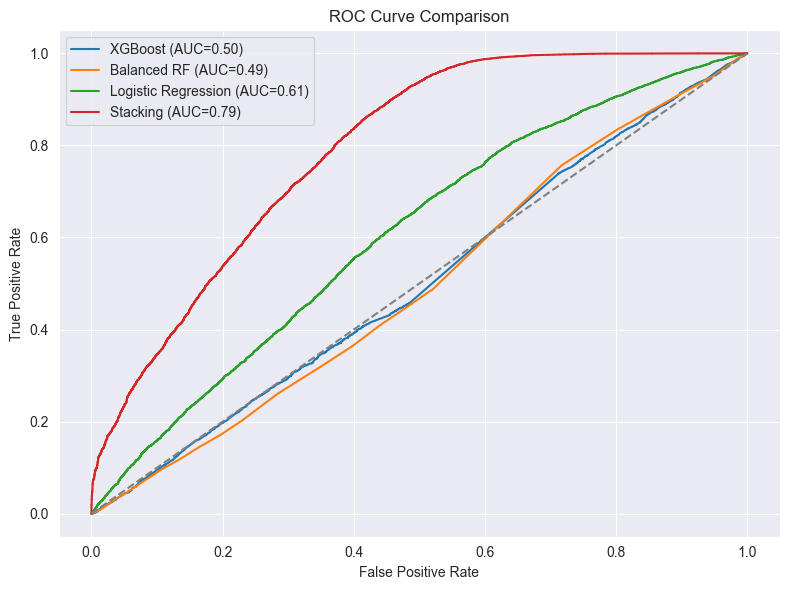

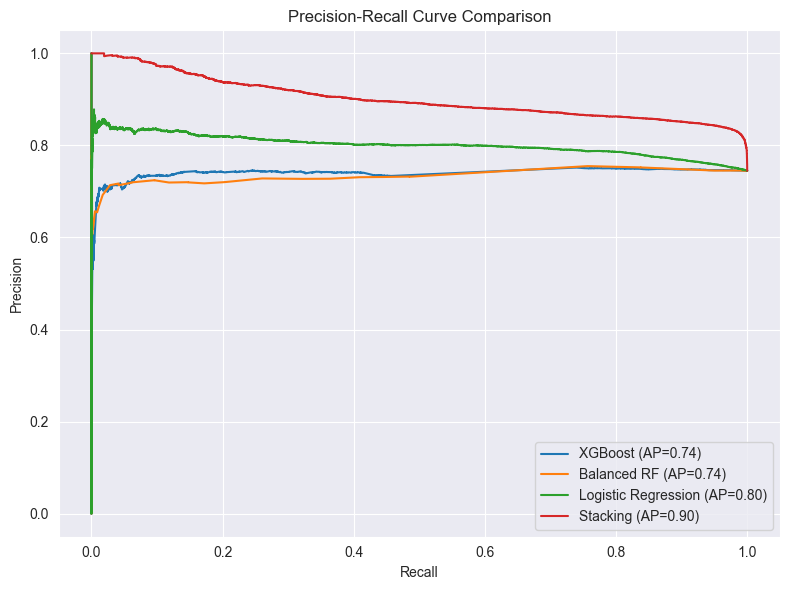

In [33]:
# Updated model list
models = {
    "XGBoost": xgb_model,
    "Balanced RF": rf_model,
    "Logistic Regression": lr_model,
    "Stacking": stack_model
}

# Store metrics and curve data for each model
model_metrics = []
model_proba_curves = {}

# Evaluation data
X_eval = X_test_scaled
y_eval = y_test

# Iterate over each model for prediction and evaluation
for name, model in models.items():
    y_pred = model.predict(X_eval)
    y_proba = model.predict_proba(X_eval)[:, 1]

    report = classification_report(y_eval, y_pred, output_dict=True)

    model_metrics.append({
        "Model": name,
        "F1-0": report.get("0", {}).get("f1-score", 0.0),
        "Recall-0": report.get("0", {}).get("recall", 0.0),
        "Precision-0": report.get("0", {}).get("precision", 0.0),
        "F1-1": report.get("1", {}).get("f1-score", 0.0),
        "Recall-1": report.get("1", {}).get("recall", 0.0),
        "Precision-1": report.get("1", {}).get("precision", 0.0)
    })

    # Calculate ROC and PR curves
    fpr, tpr, _ = roc_curve(y_eval, y_proba)
    precision, recall, _ = precision_recall_curve(y_eval, y_proba)
    auc_score = roc_auc_score(y_eval, y_proba)
    ap_score = average_precision_score(y_eval, y_proba)

    model_proba_curves[name] = {
        "fpr": fpr,
        "tpr": tpr,
        "auc": auc_score,
        "precision": precision,
        "recall": recall,
        "ap": ap_score
    }

# Visualization: Classification metrics bar chart
metrics_df = pd.DataFrame(model_metrics)
melted_df = metrics_df.melt(id_vars=["Model"], var_name="Metric", value_name="Score")

plt.figure(figsize=(14, 6))
sns.barplot(data=melted_df, x="Model", y="Score", hue="Metric")
plt.title("Model Comparison: F1, Recall, Precision (Class 0 and 1)")
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Visualization: ROC curves
plt.figure(figsize=(8, 6))
for name, data in model_proba_curves.items():
    plt.plot(data["fpr"], data["tpr"], label=f"{name} (AUC={data['auc']:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualization: Precision-Recall curves
plt.figure(figsize=(8, 6))
for name, data in model_proba_curves.items():
    plt.plot(data["recall"], data["precision"], label=f"{name} (AP={data['ap']:.2f})")
plt.title("Precision-Recall Curve Comparison")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Indicator Analysis
1. Classification Metrics
    All models generally perform well in predicting positive reviews (Class 1), but show significant differences in identifying negative reviews (Class 0). Among them, the StackingClassifier model achieves the optimal balance across F1, Recall, and Precision metrics, particularly leading by a large margin in Recall-0 and F1-0, indicating its distinct advantage in detecting minority classes. In contrast, while Logistic Regression exhibits high precision in predicting positive reviews, it almost completely fails in identifying negative reviews. Balanced Random Forest and XGBoost have limited effectiveness in addressing class imbalance, with both the recall and precision for Class 0 being relatively low.

2. ROC Curve
    The Stacking model achieves an AUC of 0.79, significantly outperforming other models, indicating its strong discriminative ability across different thresholds. For other models, although Logistic Regression achieves an AUC of 0.61, it still has the problem of ambiguous boundaries; the AUC values of XGBoost and Balanced Random Forest (Balanced RF) are 0.50 and 0.49 respectively, nearly approaching random levels, showing severely insufficient discriminative capability.

3. Precision-Recall Curve
    The Stacking model performs outstandingly with an Average Precision (AP) of 0.90. It not only maintains a high recall rate but also ensures prediction precision at high recall levels, demonstrating its stronger ability to identify negative reviews and lower misjudgment rate in practical business scenarios.

Based on the above evaluation results, the Stacking model demonstrates the best performance in terms of accuracy, robustness, and handling of class balance. It effectively integrates the advantages of multiple base models (XGBoost, RandomForest, Logistic Regression) and can stably capture complex features and boundary samples in rating tendencies. Therefore, this study finally selects the Stacking model as the model for rating prediction.
